In [1]:
import pandas as pd  # for data manipulation
import numpy as np  # for numerical operations
from sklearn.metrics.pairwise import cosine_similarity  # for calculating cosine similarity between vectors
from sklearn.preprocessing import MinMaxScaler  # for feature scaling
from fuzzywuzzy import process  # for fuzzy string matching
import matplotlib.pyplot as plt  # for creating visualizations
import seaborn as sns  # for statistical data visualization
import warnings  # for managing warnings

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 5000) # for setting the maximum number of columns to display in pandas dataframes
pd.set_option('display.max_rows', 5000) # for setting the maximum number of rows to display in pandas dataframes

In [2]:
# Load datasets
course_data = pd.read_csv('course recommendation.csv')
ranking_data = pd.read_csv('THE World University Rankings2024_rankings.csv')


In [3]:
course_data.shape

(36693, 8)

In [4]:
ranking_data.shape

(201, 23)

In [5]:
course_data.head()

,University Name,GRE AWA,GRE Quant,GRE Verbal,GPA,Degree,Course Name,Category
0,‌boston University,4.0,170.0,156.0,3.80,PhD,Aerospace and Mechanical Engineering,"STEM (Science, Technology, Engineering, Mathem..."
1,‌boston University,4.5,153.0,158.0,3.75,PhD,Anthropology,"Humanities (Languages, Literature, History, Ph..."
2,‌boston University,4.0,159.0,164.0,3.97,PhD,Art History,Arts and Design
3,‌boston University,5.0,149.0,155.0,3.76,PhD,Art History,Arts and Design
4,‌boston University,3.5,156.0,165.0,3.88,Master,Arts,Arts and Design


In [6]:
course_data['Degree'].unique()

array(['PhD', 'Master', 'Other', 'MFA', 'Both MS and PhD'], dtype=object)

In [7]:
course_data['Category'].unique()

array(['STEM (Science, Technology, Engineering, Mathematics)',
       'Humanities (Languages, Literature, History, Philosophy)',
       'Arts and Design',
       'Social Sciences (Psychology, Sociology, Political Science)',
       'Business and Economics', nan], dtype=object)

In [8]:
ranking_data.head()

,rank_order,rank,name,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,scores_citations_rank,scores_industry_income,scores_industry_income_rank,scores_international_outlook,scores_international_outlook_rank,location,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students,stats_female_male_ratio,stats_proportion_of_isr,aliases,Website
0,10,1,University of Oxford,98.5,10,96.6,5,100.0,2,99.0,5,98.7,77,97.5,14,United Kingdom,"21,750",10.9,42%,49:51:00,23%,University of Oxford,https://www.ox.ac.uk
1,20,2,Stanford University,98.0,20,99.0,1,97.8,8,99.6,2,100.0,25,87.0,168,United States,"14,517",6.4,23%,47:53:00,22%,Stanford University,https://www.stanford.edu
2,30,3,Massachusetts Institute of Technology,97.9,30,98.6,2,96.2,11,99.7,1,100.0,16,93.8,66,United States,"11,085",8.0,33%,41:59:00,40%,Massachusetts Institute of Technology,https://www.mit.edu
3,40,4,Harvard University,97.8,40,97.7,3,99.9,3,99.4,3,84.2,216,90.8,120,United States,"20,050",9.0,25%,51:49:00,12%,Harvard University,https://www.harvard.edu
4,50,5,University of Cambridge,97.5,50,95.8,7,100.0,1,98.0,12,87.9,180,97.4,15,United Kingdom,"20,565",11.5,38%,48:52:00,27%,University of Cambridge,https://www.cam.ac.uk


In [9]:
# Count the number of rows before cleaning
num_rows_before = len(course_data)
print(f"\nNumber of rows before cleaning: {num_rows_before}")

# Remove rows where Category is NaN
course_data_cleaned = course_data.dropna(subset=['Category'])

# Remove rows where Category is an empty string
course_data_cleaned = course_data_cleaned[course_data_cleaned['Category'].str.strip() != '']


# Count the number of rows after cleaning
num_rows_after = len(course_data_cleaned)
print(f"\nNumber of rows after cleaning: {num_rows_after}")


Number of rows before cleaning: 36693

Number of rows after cleaning: 26620


In [10]:
# Number of Records
print(f"Number of records in course_data: {len(course_data)}")
print(f"Number of records in ranking_data: {len(ranking_data)}")

# Number of Features
print(f"Number of features in course_data: {course_data.shape[1]}")
print(f"Number of features in ranking_data: {ranking_data.shape[1]}")

# Basic Statistics for both dataset
print("\nBasic Statistics for course_data:")
print(course_data.describe())

print("\nBasic Statistics for ranking_data:")
print(ranking_data.describe())

Number of records in course_data: 36693
Number of records in ranking_data: 201
Number of features in course_data: 8
Number of features in ranking_data: 23

Basic Statistics for course_data:
            GRE AWA     GRE Quant    GRE Verbal           GPA
count  34278.000000  35919.000000  35873.000000  34956.000000
mean       5.220863    354.498316    290.498732     23.915149
std       29.978051    282.217189    204.700849     31.601510
min        0.000000      1.000000      0.000000      0.000000
25%        3.500000    161.000000    153.000000      3.730000
50%        4.000000    167.000000    161.000000      7.490000
75%        4.500000    740.000000    500.000000     63.000000
max     1470.000000   1520.000000    801.000000    833.000000

Basic Statistics for ranking_data:
        rank_order        rank  scores_overall  scores_overall_rank  \
count   201.000000  201.000000      201.000000           201.000000   
mean   1010.000000  100.606965       70.358706          1010.000000   
std

# Check If data is small

In [11]:
 #Sample Size vs. Feature Count
num_records_course_data = len(course_data)
num_features_course_data = course_data.shape[1]

if num_records_course_data < num_features_course_data * 10:
    print("\nWarning: The number of records is less than 10 times the number of features. Dataset may be small.")
else:
    print("\nThe dataset size seems adequate relative to the number of features.")
    
   

 #Sample Size vs. Feature Count
num_records_ranking_data = len(ranking_data)
num_features_ranking_data = ranking_data.shape[1]

if num_records_ranking_data < num_features_ranking_data * 10:
    print("\nWarning: The number of records is less than 10 times the number of features. Dataset may be small.")
else:
    print("\nThe dataset size seems adequate relative to the number of features.")
    
    


The dataset size seems adequate relative to the number of features.



# Explore Course Data

In [12]:
course_data=course_data_cleaned.copy()

<Figure size 1200x1000 with 0 Axes>

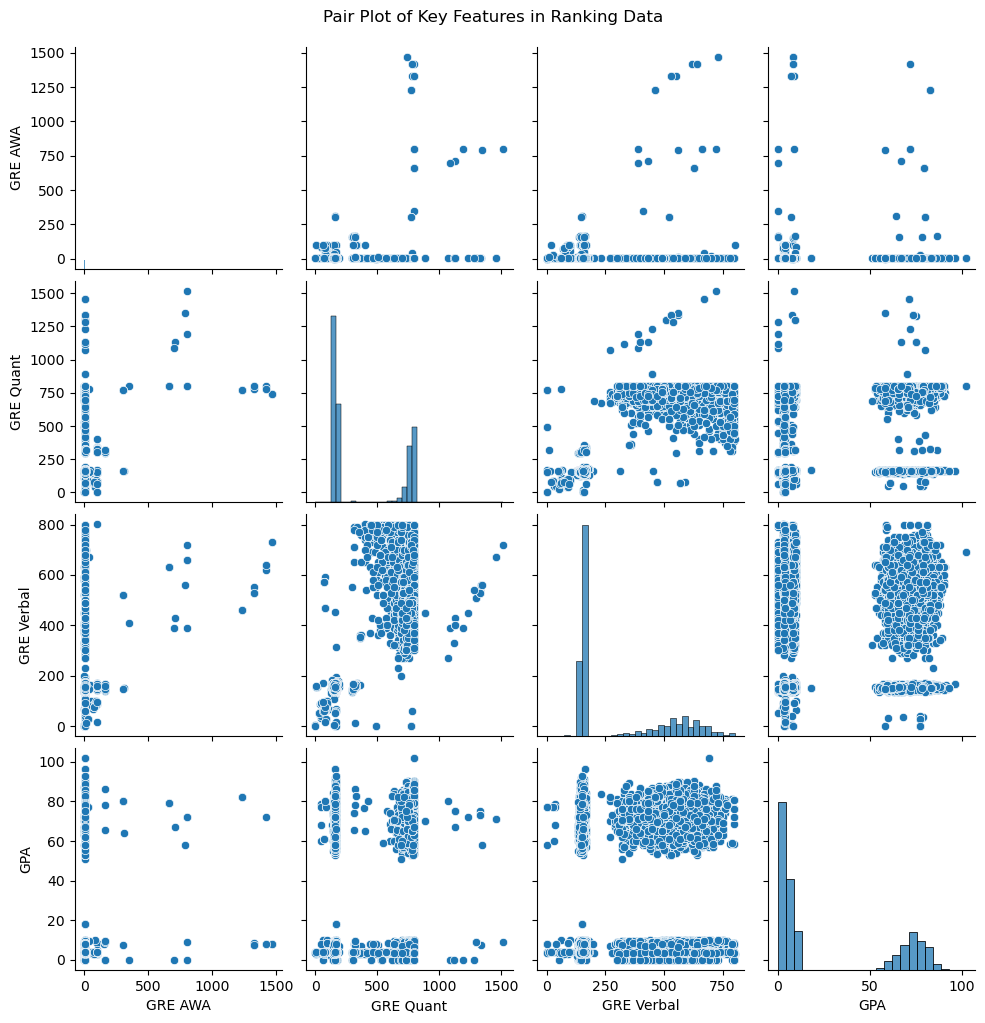

In [13]:

# Filter ranking_data to include only the selected features
selected_features = ['GRE AWA', 'GRE Quant', 'GRE Verbal', 'GPA']

# Ensure all selected features exist in the dataset
filtered_data = course_data[selected_features].dropna()

# Create a pair plot
plt.figure(figsize=(12, 10))
sns.pairplot(filtered_data)
plt.suptitle('Pair Plot of Key Features in Ranking Data', y=1.02)
plt.show()

# Explore Ranking data

<Figure size 1200x1000 with 0 Axes>

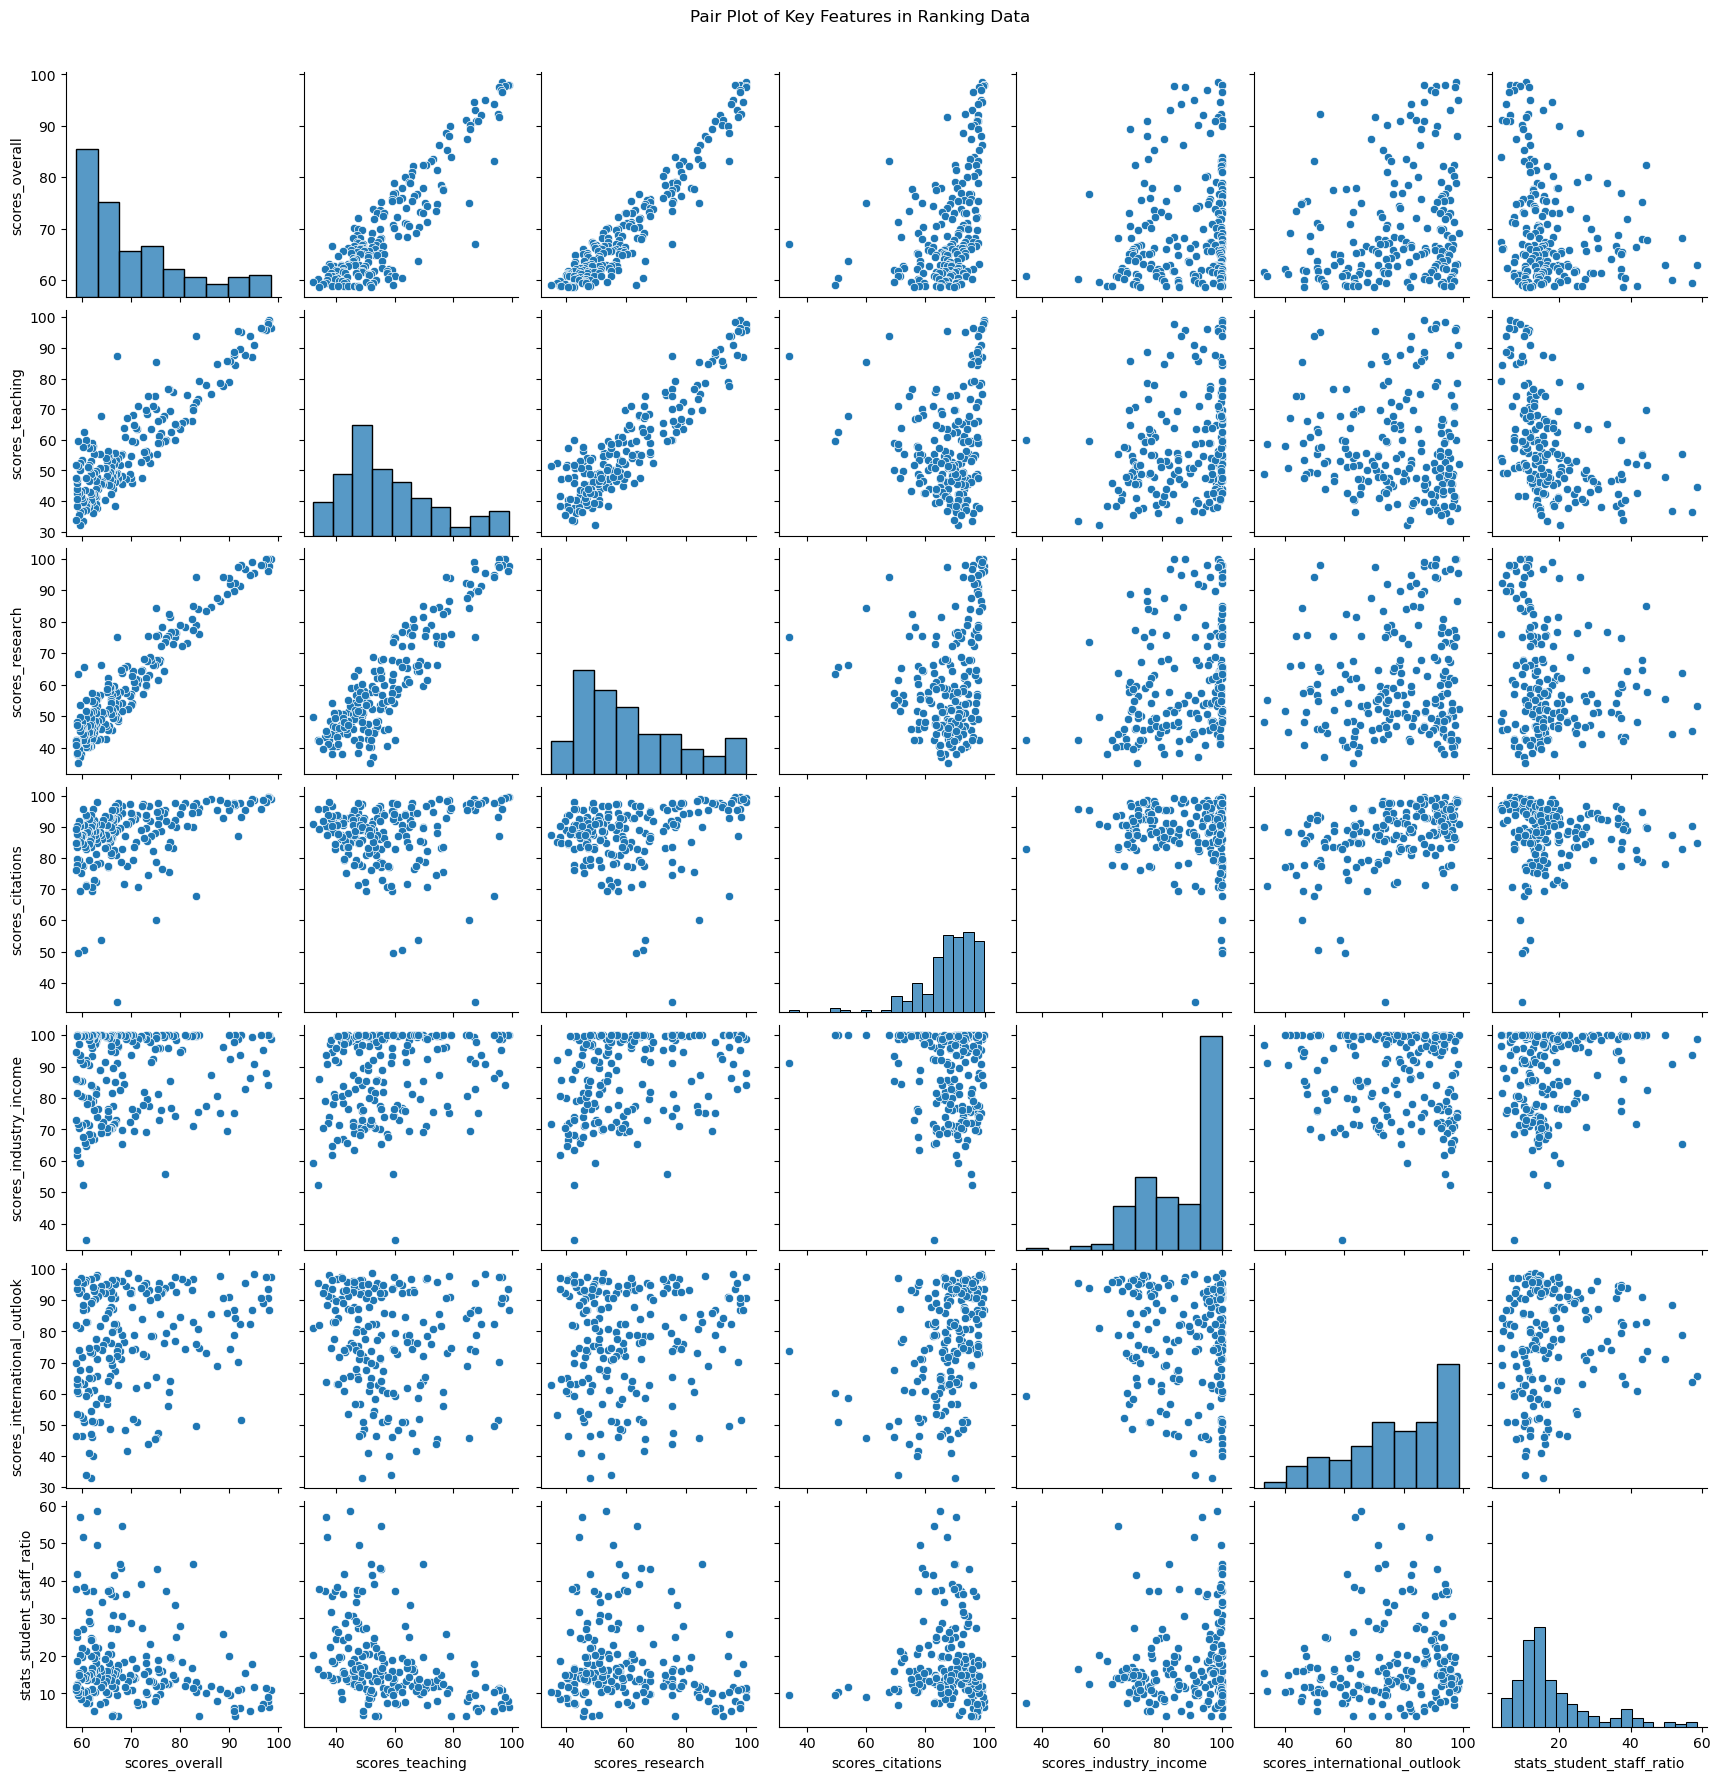

In [14]:
# Filter ranking_data to include only the selected features
selected_features = ['scores_overall', 'scores_teaching', 'scores_research', 'scores_citations',
                     'scores_industry_income', 'scores_international_outlook', 'stats_student_staff_ratio']

# Ensure all selected features exist in the dataset
filtered_data = ranking_data[selected_features].dropna()

# Create a pair plot
plt.figure(figsize=(12, 10))
sns.pairplot(filtered_data)
plt.suptitle('Pair Plot of Key Features in Ranking Data', y=1.02)
plt.show()

In [33]:
course_data = course_data_cleaned.copy()
# Drop rows with missing GRE scores, Degree, Category, or GPA in course_data
course_data = course_data.dropna(subset=['GRE AWA', 'GRE Quant', 'GRE Verbal', 'Degree', 'Category', 'GPA'])

# Fill missing numeric values in ranking data with the mean
numeric_columns = [
    'scores_overall', 'scores_teaching', 'scores_research', 'scores_citations',
    'scores_industry_income', 'scores_international_outlook', 'stats_student_staff_ratio'
]
ranking_data[numeric_columns] = ranking_data[numeric_columns].fillna(ranking_data[numeric_columns].mean())

# Normalize numeric columns in ranking data for content-based filtering
scaler = MinMaxScaler()
ranking_data[numeric_columns] = scaler.fit_transform(ranking_data[numeric_columns])

# Function to recommend universities based on content similarity (from course_data)
def content_based_recommendation(user_input):
    filtered_data = course_data[
        (course_data['Degree'] == user_input['Degree']) &
        (course_data['Category'] == user_input['Category'])
    ]

    if filtered_data.empty:
        return pd.DataFrame(columns=['University Name', 'Course Name'])

    user_profile = np.array([user_input['GRE AWA'], user_input['GRE Quant'], user_input['GRE Verbal'], user_input['GPA']]).reshape(1, -1)
    data_values = filtered_data[['GRE AWA', 'GRE Quant', 'GRE Verbal', 'GPA']].values
    content_similarity = cosine_similarity(data_values, user_profile)

    filtered_data = filtered_data.copy()
    filtered_data['content_similarity'] = content_similarity.flatten()

    top_matches = filtered_data.sort_values('content_similarity', ascending=False).head(5)
    
    return top_matches[['University Name', 'Course Name', 'content_similarity', 'Degree']]

# Function to perform fuzzy matching between course data and ranking data
def get_best_match(university_name, ranking_names):
    best_match, score = process.extractOne(university_name, ranking_names)
    return best_match if score > 80 else None

def hybrid_recommendation(user_input):
    content_based_results = content_based_recommendation(user_input)
    
    if content_based_results.empty:
        return pd.DataFrame(columns=['University Name', 'Location', 'Rank', 'Overall Score', 'Website', 'Course Name', 'Degree'])

    ranking_names = ranking_data['name'].tolist()
    content_based_results['matched_name'] = content_based_results['University Name'].apply(lambda x: get_best_match(x, ranking_names))

    combined_results = pd.merge(
        content_based_results, ranking_data, 
        left_on='matched_name',
        right_on='name', 
        how='left'
    )

    if 'content_similarity' not in combined_results.columns:
        return pd.DataFrame(columns=['University Name', 'Location', 'Rank', 'Overall Score', 'Website', 'Course Name', 'Degree'])

    weightings = {
        'scores_teaching': 0.2,
        'scores_research': 0.2,
        'scores_citations': 0.2,
        'scores_industry_income': 0.2,
        'scores_international_outlook': 0.2
    }

    combined_results['weighted_score'] = (
        combined_results['scores_teaching'] * weightings['scores_teaching'] +
        combined_results['scores_research'] * weightings['scores_research'] +
        combined_results['scores_citations'] * weightings['scores_citations'] +
        combined_results['scores_industry_income'] * weightings['scores_industry_income'] +
        combined_results['scores_international_outlook'] * weightings['scores_international_outlook']
    )

    combined_results = combined_results[[
        'University Name', 'location', 'rank', 'scores_overall', 'Website', 'Course Name', 'Degree', 'content_similarity', 'weighted_score',
        'scores_overall_rank', 'scores_teaching_rank', 'scores_research_rank', 'scores_citations_rank',
        'scores_industry_income_rank', 'scores_international_outlook_rank', 'stats_student_staff_ratio',
        'stats_pc_intl_students', 'stats_female_male_ratio'
    ]]

    combined_results = combined_results.rename(columns={
        'rank': 'Rank',
        'location': 'Location',
        'stats_student_staff_ratio': 'Student-Staff Ratio',
        'stats_pc_intl_students': '% International Students',
        'stats_female_male_ratio': 'Female-Male Ratio'
    })

    combined_results['Student-Staff Ratio'] = combined_results['Student-Staff Ratio'].apply(lambda x: f"{x:.2f}")
    combined_results['Female-Male Ratio'] = combined_results['Female-Male Ratio'].apply(lambda x: f"{int(x.split(':')[0]):02d}:{int(x.split(':')[1]):02d}")

    combined_results['content_similarity'] = (combined_results['content_similarity'] * 100).round(2)
    combined_results['weighted_score'] = (combined_results['weighted_score'] * 100).round(2)
    combined_results['hybrid_score'] = (combined_results['content_similarity'] * 0.5 + combined_results['weighted_score'] * 0.5).round(2)
    
    final_recommendations = combined_results.sort_values('hybrid_score', ascending=False).head(5)

    return final_recommendations


# Example user input
user_input = {
    'GRE AWA': 4,
    'GRE Quant': 142,
    'GRE Verbal': 165,
    'GPA': 3.7,
    'Degree': 'Master',
    'Category': 'STEM (Science, Technology, Engineering, Mathematics)'
}

# Generate recommendations
recommendations = hybrid_recommendation(user_input)

# Display recommendations
print(recommendations)


                     University Name       Location  Rank  scores_overall  \
3             Stony Brook University  United States     9        0.902010   
0    Georgia Institute Of Technology  United States    36        0.535176   
2  University Of Southern California  United States    74        0.304020   
4           Florida State University  United States   132        0.125628   
1           Arizona State University  United States   182        0.030151   

                              Website           Course Name  Degree  \
3            https://www.berkeley.edu      Computer Science  Master   
0              https://www.gatech.edu      Computer Science  Master   
2  https://www.sorbonne-universite.fr      Computer Science  Master   
4           https://www.rochester.edu      Computer Science  Master   
1                                 NaN  Chemical Engineering  Master   

   content_similarity  weighted_score  scores_overall_rank  \
3               100.0           92.09           

In [34]:
recommendations.columns

Index(['University Name', 'Location', 'Rank', 'scores_overall', 'Website',
       'Course Name', 'Degree', 'content_similarity', 'weighted_score',
       'scores_overall_rank', 'scores_teaching_rank', 'scores_research_rank',
       'scores_citations_rank', 'scores_industry_income_rank',
       'scores_international_outlook_rank', 'Student-Staff Ratio',
       '% International Students', 'Female-Male Ratio', 'hybrid_score'],
      dtype='object')

In [35]:
recommendations.head()

,University Name,Location,Rank,scores_overall,Website,Course Name,Degree,content_similarity,weighted_score,scores_overall_rank,scores_teaching_rank,scores_research_rank,scores_citations_rank,scores_industry_income_rank,scores_international_outlook_rank,Student-Staff Ratio,% International Students,Female-Male Ratio,hybrid_score
3,Stony Brook University,United States,9,0.902010,https://www.berkeley.edu,Computer Science,Master,100.0,92.09,90,18,4,4,63,172,0.26,22%,52:48,96.04
0,Georgia Institute Of Technology,United States,36,0.535176,https://www.gatech.edu,Computer Science,Master,100.0,75.28,360,63,33,57,123,191,0.44,29%,34:66,87.64
2,University Of Southern California,United States,74,0.304020,https://www.sorbonne-universite.fr,Computer Science,Master,100.0,57.96,740,79,90,85,345,346,0.19,24%,49:51,78.98
4,Florida State University,United States,132,0.125628,https://www.rochester.edu,Computer Science,Master,100.0,49.23,1320,93,103,357,174,776,0.23,9%,56:44,74.61
1,Arizona State University,United States,182,0.030151,NaN,Chemical Engineering,Master,100.0,45.41,1820,280,177,161,395,379,0.29,14%,46:54,72.70


In [36]:
# Example user input with GPA Testing
user_input = {
    'GRE AWA': 4,
    'GRE Quant': 142,
    'GRE Verbal': 165,
    'GPA': 3.7,
    'Degree': 'Master',
    'Category': 'STEM (Science, Technology, Engineering, Mathematics)'
}

# Generate hybrid recommendations
recommendations = hybrid_recommendation(user_input)
print("Final Recommendations:")
recommendations.head()


Final Recommendations:


,University Name,Location,Rank,scores_overall,Website,Course Name,Degree,content_similarity,weighted_score,scores_overall_rank,scores_teaching_rank,scores_research_rank,scores_citations_rank,scores_industry_income_rank,scores_international_outlook_rank,Student-Staff Ratio,% International Students,Female-Male Ratio,hybrid_score
3,Stony Brook University,United States,9,0.902010,https://www.berkeley.edu,Computer Science,Master,100.0,92.09,90,18,4,4,63,172,0.26,22%,52:48,96.04
0,Georgia Institute Of Technology,United States,36,0.535176,https://www.gatech.edu,Computer Science,Master,100.0,75.28,360,63,33,57,123,191,0.44,29%,34:66,87.64
2,University Of Southern California,United States,74,0.304020,https://www.sorbonne-universite.fr,Computer Science,Master,100.0,57.96,740,79,90,85,345,346,0.19,24%,49:51,78.98
4,Florida State University,United States,132,0.125628,https://www.rochester.edu,Computer Science,Master,100.0,49.23,1320,93,103,357,174,776,0.23,9%,56:44,74.61
1,Arizona State University,United States,182,0.030151,NaN,Chemical Engineering,Master,100.0,45.41,1820,280,177,161,395,379,0.29,14%,46:54,72.70


# Evaluation method
1. nDCG - 
    * Normalized Discounted Cumulative Gain, nDCG measures how well a model ranks items, considering both the relevance of items and their position in the ranked list.
    * Higher nDCG values indicate better ranking quality
    * We will check at each position like K1 top rnaked, k=3 top tree and so on. Good rule is top 5
2. Offline testing- 
    * Using historical data to simulate user behavior and assess model performance.

In [37]:
# nDCG Calculation Functions
def dcg_at_k(relevances, k):
    relevances = np.array(relevances)[:k]
    if relevances.size:
        return np.sum(relevances / np.log2(np.arange(2, relevances.size + 2)))
    return 0.0

def ndcg_at_k(relevances, k):
    dcg = dcg_at_k(relevances, k)
    ideal_relevances = sorted(relevances, reverse=True)
    idcg = dcg_at_k(ideal_relevances, k)
    if idcg == 0:
        return 0
    return dcg / idcg

# scores based on 'content_similarity' and 'weighted_score'
relevance_scores = recommendations['content_similarity'].tolist() + recommendations['weighted_score'].tolist()

# Define positions to evaluate
positions = [1, 3, 5, 10]
ndcg_scores = []

# Computing nDCG scores for different positions
for k in positions:
    ndcg_score = ndcg_at_k(relevance_scores, k)
    ndcg_scores.append(ndcg_score)
    print(f"Relevance Scores for k={k}: {relevance_scores[:k]}")
    print(f"nDCG Score for k={k}: {ndcg_score:.4f}")


Relevance Scores for k=1: [100.0]
nDCG Score for k=1: 1.0000
Relevance Scores for k=3: [100.0, 100.0, 100.0]
nDCG Score for k=3: 1.0000
Relevance Scores for k=5: [100.0, 100.0, 100.0, 100.0, 100.0]
nDCG Score for k=5: 1.0000
Relevance Scores for k=10: [100.0, 100.0, 100.0, 100.0, 100.0, 92.09, 75.28, 57.96, 49.23, 45.41]
nDCG Score for k=10: 1.0000


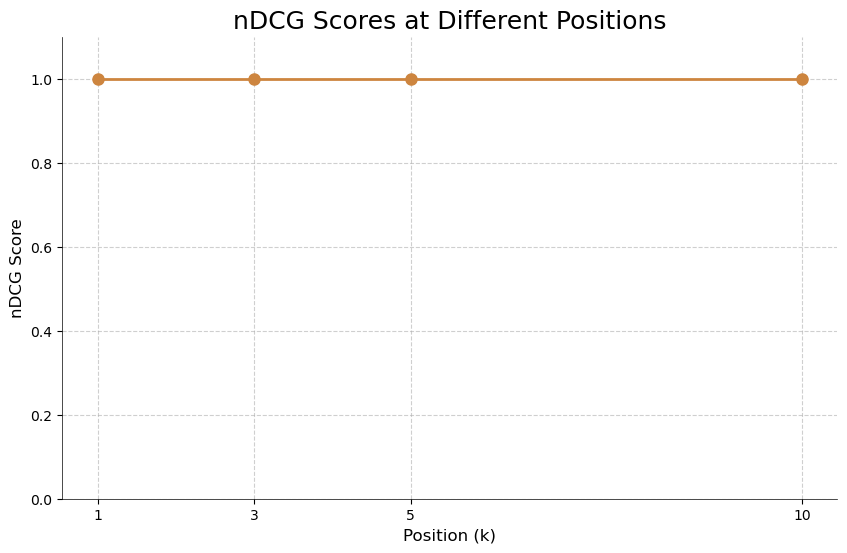

In [38]:
# Plot with custom style
plt.figure(figsize=(10, 6))
plt.plot(positions, ndcg_scores, marker='o', linestyle='-', color='#cd853f', markersize=8, linewidth=2)

# Customize labels and title with a clean look
plt.xlabel('Position (k)', fontsize=12)
plt.ylabel('nDCG Score', fontsize=12)
plt.title('nDCG Scores at Different Positions', fontsize=18)

# Customize grid and ticks
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(positions, fontsize=10)
plt.yticks(fontsize=10)

# Remove outer box and frame
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)

# Set y-axis limits for better visibility
plt.ylim(0, 1.1)


plt.savefig("nDCG Scores at Different Positions.png")
# Show plot
plt.show()

n nDCG score of 1.0000 at position 5 indicates perfect ranking quality for your recommendations based on the provided relevance scores and the criteria used. This means that the top 5 recommendations are exactly as good as they could be according to your relevance scoring system.

* The relevance scores used in the nDCG calculation (in this case, content_similarity and weighted_score) are well-aligned with user needs or expectations.